In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

from keras_preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras.applications.vgg19 import VGG19
from sklearn.metrics import *

In [2]:
input_dir = '/kaggle/input'

sample_dir = os.path.join(input_dir, 'sample/')
csv_dir = os.path.join(input_dir, 'nihsample')
images_dir = os.path.join(sample_dir, 'sample/sample/images')

In [3]:
training_file = os.path.join(csv_dir, 'train_data.csv')
testing_file = os.path.join(csv_dir, 'test_data.csv')

training_df = pd.read_csv(training_file, index_col=0)
testing_df = pd.read_csv(testing_file, index_col=0)

training_df['pneumonia'] = training_df['pneumonia'].astype(str)
testing_df['pneumonia'] = testing_df['pneumonia'].astype(str)

In [4]:
batch_size = 64
image_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255.,  
    horizontal_flip = True, 
    vertical_flip = False, 
    height_shift_range= 0.1, 
    width_shift_range=0.1, 
    rotation_range=30,
    shear_range = 0.1,
    zoom_range=0.2,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255.)

In [5]:
train_generator=train_datagen.flow_from_dataframe(
    dataframe=training_df,
    directory=images_dir,
    x_col="image_index",
    y_col='pneumonia', 
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode='binary',
    target_size=image_size,
    subset='training',
    color_mode='rgb'
)

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=training_df,
    directory=images_dir,
    x_col="image_index",
    y_col='pneumonia', 
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode='binary',
    target_size=image_size,
    subset='validation',
    color_mode='rgb'
)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=testing_df,
    directory=images_dir,
    x_col="image_index",
    y_col='pneumonia',
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode='binary',
    target_size=image_size,
    color_mode='rgb'
)

Found 3588 validated image filenames belonging to 2 classes.
Found 897 validated image filenames belonging to 2 classes.
Found 1121 validated image filenames belonging to 2 classes.


In [6]:
num_classes = 1

IMG_WIDTH, IMG_HEIGHT = image_size

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

base_model.trainable = False

model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(2156, activation = 'relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1280, activation = 'relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(540, activation = 'relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation = 'sigmoid')
])

model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2156)              54091884  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2156)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1280)              2760960   
_________________________________________________________

In [7]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
loss, accuracy = model.evaluate(test_generator)

print('\nLoss before training: {:,.3f}'.format(loss))
print('Accuracy before training: {:.3%}'.format(accuracy))

18/18 [==============================] - 20s 1s/step - loss: 0.6930 - accuracy: 0.5682

Loss before training: 0.693
Accuracy before training: 56.824%


In [9]:
EPOCHS = 100

model_file = os.path.join('model.h5')

early_stopping = tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss', 
                    patience=5,
                    restore_best_weights=True
                 )

save_best = tf.keras.callbacks.ModelCheckpoint(
                model_file, 
                monitor='val_accuracy', 
                save_best_only=True
            )

history = model.fit(
    train_generator, 
    epochs = EPOCHS, 
    validation_data=valid_generator, 
    callbacks=[early_stopping, save_best]
)

Epoch 1/100
57/57 [==============================] - 134s 2s/step - loss: 1.7827 - accuracy: 0.4986 - val_loss: 0.7344 - val_accuracy: 0.5072
Epoch 2/100
57/57 [==============================] - 127s 2s/step - loss: 0.7090 - accuracy: 0.5281 - val_loss: 0.6736 - val_accuracy: 0.5753
Epoch 3/100
57/57 [==============================] - 127s 2s/step - loss: 0.6972 - accuracy: 0.5329 - val_loss: 0.6823 - val_accuracy: 0.5251
Epoch 4/100
57/57 [==============================] - 130s 2s/step - loss: 0.6726 - accuracy: 0.5711 - val_loss: 0.6405 - val_accuracy: 0.6232
Epoch 5/100
57/57 [==============================] - 130s 2s/step - loss: 0.6490 - accuracy: 0.6193 - val_loss: 0.5982 - val_accuracy: 0.6957
Epoch 6/100
57/57 [==============================] - 129s 2s/step - loss: 0.6469 - accuracy: 0.5831 - val_loss: 0.6119 - val_accuracy: 0.6767
Epoch 7/100
57/57 [==============================] - 130s 2s/step - loss: 0.6270 - accuracy: 0.6240 - val_loss: 0.6362 - val_accuracy: 0.6867
Epoch 

In [10]:
loss, accuracy = model.evaluate(test_generator)

print('\nLoss after training: {:,.3f}'.format(loss))
print('Accuracy after training: {:.3%}'.format(accuracy))

18/18 [==============================] - 19s 1s/step - loss: 0.5897 - accuracy: 0.6539

Loss after training: 0.590
Accuracy after training: 65.388%


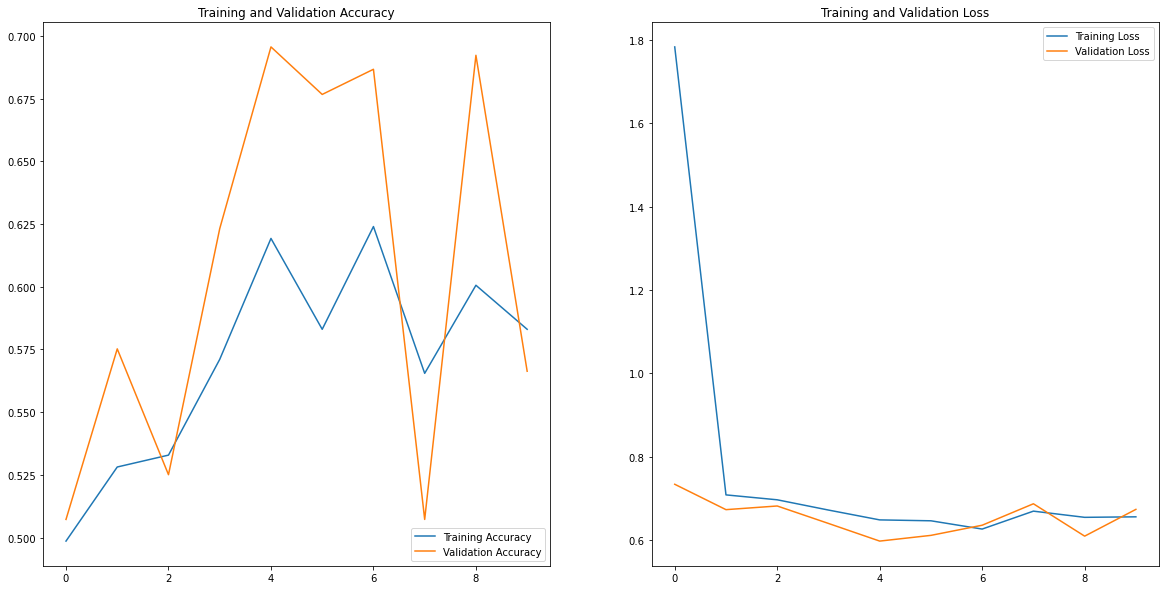

In [11]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()